# SIN Anchors:


In [1]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

In [2]:
tablas = 8
n_grupo = 4

d = {}
D = "Dataset"
for i in range(0,tablas):
    d["group" + str(i)] = pd.read_excel("datasets.ods", sheet_name=D+str(i+1))
    print('Fichero leído:',i, 'tamaño', d["group" + str(i)].shape)

Fichero leído: 0 tamaño (227, 183)
Fichero leído: 1 tamaño (227, 183)
Fichero leído: 2 tamaño (227, 183)
Fichero leído: 3 tamaño (227, 183)
Fichero leído: 4 tamaño (227, 183)
Fichero leído: 5 tamaño (227, 183)
Fichero leído: 6 tamaño (227, 183)
Fichero leído: 7 tamaño (227, 183)


In [3]:
## Vamos a meter los Dataset en una hipermatriz M , donde cada capa es un dataset
rows = d["group" + str(i)].shape[0] - 3
columns = d["group" + str(i)].shape[1] - 3
#En el excel empieza en (5,4). Es decir una diferencia de 5 y 4 respecto a los números que saquemos


M = np.zeros((tablas,rows,columns))

for i in range(0, tablas):
    Data = d['group' + str(i)]
    M[i,:,:] = Data.iloc[3:,3:]

## No son cuadradas, pero puede que a mí me interese que lo sean (y llenar lo que sobre de ceros)
M_square = np.zeros((tablas, rows, rows))
M_square[:,:, 0:columns] = M[:,:,:]


#Lo queremos BINARIO, ignorando su peso (Luego pensar cómo se haría con el peso)
M_bin = np.zeros((tablas,rows,columns))
M_square_bin = np.zeros((tablas,rows,rows))
for i in range(tablas):
    for j in range(rows):
        for k in range(columns):
            if (M[i,j,k] >= 1):
                M_bin[i,j,k] = 1
                M_square_bin[i,j,k] = 1
                
Nx = rows
print('Filas:',rows)

Filas: 224


## FUNCIONES DE ENERGÍA

In [4]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):
    n1 = int(Edges_L + alpha + beta - 2)
    k1 = overlap_1 + alpha -1
    
    n0 = int(Edges_NoL + alpha + beta - 2)
    k0 = overlap_0 + alpha - 1
    
    # !!!! Con numba los factoriales grandes dan errores: usar [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(n1+1)- math.lgamma(k1+1) - math.lgamma(n1-k1 +1) + math.log( Edges_L + alpha+beta-1)
    H0 = math.lgamma(n0+1)- math.lgamma(k0+1) - math.lgamma(n0-k0 +1) + math.log( Edges_NoL + alpha+beta-1)
    
    H = H1 + H0

    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): #Overlap de cada fila (pero no lo necesitamos guardar, solo queremos el total)
            for c in range(0,Nx):
            #El overlap depende de la permutación!
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])           
            
                if (L_f[f,c] == A_f[k,p_f,p_c]): #Antes tenía esto al revés
                    if (L_f[f,c] == 1):
                        ovlp_1[k] = ovlp_1[k]+1
                    else:
                        ovlp_0[k] = ovlp_0[k] +1

    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0))
   
    return ovlp_0, ovlp_1


@jit(nopython=True)
def hamiltonian(Edges, overlap, alpha, beta):
    n = int(Edges+alpha+beta-2)
    k = overlap+alpha-1
    # !!!! Con numba los factoriales grandes dan errores: usar [ math.lgamma(n+1) == log(n!) ]
    H = math.lgamma(n+1)- math.lgamma(k+1) - math.lgamma(n-k+1) + math.log( Edges+alpha+beta-1)
    return H

@jit(nopython=True)
def deltaE(Edges, overlap, alpha, beta, delta_o):
    abs_o=abs(delta_o)
    logaritmo_b = 0  #Lo tengo que hacer por separad
    logaritmo_ab = 0
    
    A_max = Edges + alpha + beta -2 #Mirar pag 18 del cuaderno de bitácora
    B_max = overlap + delta_o + alpha -1

    if (delta_o<0):        
      
        logaritmo_b = math.lgamma((B_max + abs_o) + 1) - math.lgamma(B_max + 1)
        logaritmo_ab = math.lgamma(A_max - B_max +1) - math.lgamma(A_max - (B_max + abs_o)+1)
        logaritmo =  logaritmo_b - logaritmo_ab

        dE = logaritmo
        
    else:
        
        logaritmo_ab = math.lgamma(A_max - B_max + abs_o + 1) - math.lgamma(A_max - B_max + 1)
        logaritmo_b = math.lgamma(B_max + 1) - math.lgamma(B_max - abs_o + 1)   
        logaritmo = logaritmo_b - logaritmo_ab
        
        dE = -logaritmo   
        
    return dE 

@jit(nopython=True)
def overlap_total(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_f=np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): #Overlap de cada fila (pero no lo necesitamos guardar, solo queremos el total)
            for c in range(0,Nx):
            #El overlap depende de la permutación!
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])           
            
                if (L_f[f][c] == A_f[k,p_f,p_c]): #Antes tenía esto al revés
                    ovlp_f[k] = ovlp_f[k]+1

    ovlp_f=int(sum(ovlp_f))
   
    return ovlp_f

@jit(nopython=True)
def L_wiring(A_f, P_inv_f):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
                #Necesito la permutación
                p1 = int(P_inv_f[k,i]) #A la fila y columna i de L, la fila y columna que le corresponde en A
                p2 = int(P_inv_f[k,j]) #A la fila y columna j de L, la fila y columna que le corresponde en A
                L_new_f[i,j] += A_f[k,p1,p2]
            
#             print('i,j', i,j,'L_new', L_new_)
            valor_lnew=1/K* L_new_f[i,j]
            if (valor_lnew!=0.5):#Para que el 0.5 no siempre me lo redondee hacia arriba o hacia abajo
                L_new_f[i,j] = round( valor_lnew )
            else:
                L_new_f[i,j] =np.random.randint(2)
            #MIRAR BOOLEANOS
            #L_new[i][j] = round( 1/K* L_new[i][j])*(L_new!=0.5)+np.random.randint(1)*(L_new==0.5) 

    #Recalculamiento de energia
    
    
    return L_new_f


#Este tiene en cuenta una lista secundaria
#(que puede ser por ejemplo el hub de mayor tamaño)
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    #print('dentro:',array, begin, end)
    if end is None:
        end = len(array) - 1
    if begin >= end: #Para acabar el algoritmo
        return
    pivot = partition(array,  etiquetas, begin, end)
    #print('pivot', pivot, 'array', array)
    
    #Aquí ordenamos la derecha y la izquierda
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    


# CONDICIONES INICIALES Y GRUPOS

Ahora es cuando vamos a poner los unkwons!

In [5]:
# Por ahora no las sé buscar en excell pero seguramente no sea difícil leer celdas
Sensory = 69-5 #0
Inter = 113-70 # 1
Motor = 155-114 #2
Modulatory = 184-156 #3
Muscle = 216-185 #4 
Others = 228-217 #5

size_groups = np.array([Sensory, Inter, Motor, Modulatory, Muscle, Others]) + 1 #Porque empezamos en cero
n_groups = len(size_groups)
start_groups = np.zeros(n_groups) #En que posición empieza cada grupo
end_groups = np.zeros(n_groups)


print('grupos: Sensory, Inter, Motor, Modulatory, Muscle, Other')
print('SIZE GROUPS:', size_groups)
#Para evitar trabajar con diccionarios (por NUMBA), vamos a hacer matrices 
# Cada matriz tiene el tamaño de la de mayor, pero luego las vamos cortando
rows_g, columns_g = size_groups.max(), size_groups.max()
G = np.zeros((tablas, n_groups, rows_g, columns_g))  #Aunque en las matrices G no voy a estar muy interesada
labels = np.zeros((rows))

size_suma = 0
start_groups[0] = 0

for i in range(n_groups):
    size = size_groups[i]
    if (i!=n_groups-1):
        start_groups[i+1] = int(size_suma + size)
    for i_label in range(size_suma, size + size_suma):
        labels[i_label] = i
        
    G[:,i, :size,  :size] = M_square[:, size_suma:(size + size_suma), size_suma :(size + size_suma)] 
    size_suma = size_suma + (size) 

    

g1 = int((start_groups[-2]))

for i in range(0,n_groups):
    if (i!= n_groups-1):
        end_groups[i] = start_groups[i+1]
    else:
        end_groups[i] = Nx
start_groups = start_groups.astype(int)
end_groups = end_groups.astype(int)

print('***********************************')
print('Primer nodo de cada grupo', start_groups)
print('Último nodo de cada grupo', end_groups)



grupos: Sensory, Inter, Motor, Modulatory, Muscle, Other
SIZE GROUPS: [65 44 42 29 32 12]
***********************************
Primer nodo de cada grupo [  0  65 109 151 180 212]
Último nodo de cada grupo [ 65 109 151 180 212 224]


## C-elegants

Cogemos los estadios más evolucionados: A2,A1, L4,L3

In [135]:
### DATOS
Nx, Ny = rows, rows #Nodos en la red
#Nx, Ny = rows, columns

qn = 0.9 #Prob copia de nodo
qe = 0.2 #Prob copia de edge
K = 4 #tablas #Matrices copiadas K
alpha,beta = 5,2 #Distribución beta que usamos
Edges = Nx*Ny #Entradas de la matriz de adjacency
micropasos = Edges*K #Para pasar por todas las posibilidades

np.random.seed( random.randint(1,1999) )
dic = pickle.load(open("Matriz_unkwn_epochs_A.pickle", "rb"))
A = dic["A"]
                
print('MATRICES OBSERVACIÓN')  
print(A.shape)
print(np.sum(A))
####################################
## CONDICIONES INICIALES ##
L_ini = np.zeros((Nx,Ny))
P_ini_0 = np.zeros((K,Nx))
P_inv_ini_0 = np.zeros((K,Nx))
L_ini = (A[0,:,:]).copy()

groups_ini = np.zeros((K,Nx))
for m1 in range(K):
    for i_g in range(n_groups):
        start = start_groups[i_g]
        end = end_groups[i_g]
        groups_ini[m1, start:end] = i_g
groups_ini_0 = groups_ini.copy()

MATRICES OBSERVACIÓN
(4, 224, 224)
7428.0


In [137]:
#Vamos a ordenar igual las etiquetas de nodos con las de a que grupo pertenecen
def permu_groups_unk_capa1(L_f, A_f, start_f, unkwn, grupos_t_f): #En este caso no lo voy a hacer con anchors
    #num_unkw: los números de unkwn que no sabemos
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    #Matrices permutación y sus inversas
    P_f = np.zeros((K,Nx))
    P_inv_f = np.zeros((K,Nx))
    P_new = np.zeros((K,Nx))
    
    #Vamos a ordenar las matrices Observación según el grado de los nodos de L_inf
    orden_L_in = np.zeros((Nx))
    array_L = np.arange(Nx)

    for i in range(Nx):
        b = np.nonzero(L_f[i,:])
        orden_L_in[i] = b[0].size#.size

    orden_L = orden_L_in.copy()
    quicksort(orden_L, array_L)
    array_L = array_L[::-1]
    
    grupos_L = np.zeros((Nx))
    for  i_g in range(N_groups):
        start = start_f[i_g]
        if (i_g != N_groups-1):
            end = start_f[i_g+1]
        else:
            end = Nx
        grupos_L[start:end] = i_g
    grupos_L = grupos_L.astype(int)
    orden_L = orden_L_in.copy()
    quicksort(orden_L, grupos_L )
    grupos_L = grupos_L[::-1]
    # print('L', grupos_L) 
    
    #Órdenes de A
    for i in range(0,K):
        orden_A_in = np.zeros((Nx))
        grupos_A = np.zeros((Nx))
        array_A = np.arange(Nx) #Para las etiquetas

        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A_in[i_orden] = b[0].size
            grupos_A[i_orden] = grupos_t_f[i, i_orden]

        orden_A = orden_A_in.copy()
        quicksort(orden_A, array_A)
        array_A = array_A[::-1]

        ## Ahora empiezo a ordenarlos según el tipo 
        orden_A = orden_A_in.copy()
        quicksort(orden_A, grupos_A)
        grupos_A = grupos_A[::-1]

        # print('i_k', i, 'A', grupos_A)
        
        array_A_L = np.zeros((Nx))
        for i_n in range(Nx):
            if ((grupos_A[i_n] == grupos_L[i_n]) or (grupos_A[i_n] == N_groups)):
                array_A_L[i_n] = array_A[i_n]
            else:
                # Busco el siguiente del mismo grupo y lo cambio
                count = 0
                for i_nn in range(i_n, Nx):
                    if ((grupos_A[i_nn] == grupos_L[i_n]) or (grupos_A[i_nn] == N_groups)): 
                        array_A_L[i_n] = array_A[i_nn]
                        #Cambio
                        array_A[i_nn] = array_A[i_n]
                        aux = grupos_A[i_nn]
                        grupos_A[i_nn] = grupos_A[i_n]
                        grupos_A[i_n] = aux
                        count = 1
                        break
                if (count == 0):
                    # Significa que no ha entrado en ninguno
                    # Necesita hacer un cambio con un unkwon del grupo que sea
                    grupo = grupos_A[i_n]

                    extras_A = np.where( grupos_A == N_groups)[0]
                    extras_L = np.where(grupos_L == grupo)[0]
         
                    inter = np.array(list(set(extras_A).intersection(extras_L)))
                    # print(extras_A, extras_L, '// grupo', grupo)
                    unkwn_1 = random.choice(inter)
                    
                    # Coloco
                    array_A_L[i_n] = array_A_L[unkwn_1]
                    # Cambio
                    array_A_L[unkwn_1] = array_A[i_n]
                    aux = grupos_A[unkwn_1]
                    grupos_A[unkwn_1] = grupos_A[i_n]
                    grupos_A[i_n] = grupos_A[unkwn_1]


        array_A_L = array_A_L[np.argsort(array_L)]
        P_inv_f[i,:] = array_A_L
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_inv_f[i,i_inv] == j_inv):
                    P_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()

    return P_todo

In [191]:
# Hay que ordenar las permutaciones como si hubiera 6 grupos y uno es el de los unkwons

# LISTA DE UNKWONS DE LAS LAYERS:Cogemos aleatoriamente num de cada grupo
# Le tenemos que poner la etiqeta del grupo al que pertenecen
group_extra = (n_groups-1) + 1

# Ahora el número de nodos depende del grupo
num = np.zeros((K, n_groups))
###################### PRIMERA CAPA TODOS CONOCIDOS #####################################
num[:-1,:] = np.round(size_groups*0.1)
########################################################################################

num_unk = np.zeros(K) # En cada capa puede tener un número diferente de unkwns (AHORA NO)
for i in range(K):
    num_unk[i] = sum(num[i,:])

num = num.astype(int)
num_unk = num_unk.astype(int)
# Voy a hacer vectores del máximo. Los que no lleguen al máximo los ponemos con Nx+1 o un número alto (ahora no implementado)
max_num = (np.amax(num_unk))
    
posi_unkwons_ini = np.zeros ((K,max_num))+ (Nx+1) # Esto son los unkwons que luego voy a mezclar
labels_unkwons_ini = np.zeros ((K,max_num)) + (Nx+1)

groups_ini_permu = np.zeros((K,Nx))

####### Para el mismo número de nodos no hace falta correrlo en cada capa
# count = 0
# for i_g in range(n_groups):
#     start = start_groups[i_g]
#     end = end_groups[i_g]
#     groups_ini[:,start:end] = i_g
#     groups_ini_0[:,start:end] = i_g
#     nodos = []
#     for i_un in range(num[1,i_g]):
#         nodo1 = np.random.randint(start,end)
# ##### No queremos que esté en Anchors justo los que hemos cogido
#         while ((nodo1 in nodos) ):
#             nodo1 = np.random.randint(start,end)
#         groups_ini[1:,nodo1] = group_extra
#         nodos.append(nodo1)
#         labels_unkwons_ini[1:, count] = nodo1            
#         count +=1
### PAra distinto número
###########################################################
for m1 in range(K):
    count = 0
    # Si no llega al maximo rellenamos el final
    if (num_unk[m1]< max_num):
        extras = int(max_num - num_unk[m1])
        labels_unkwons_ini[m1, - extras: ] = Nx+1
    for i_g in range(n_groups):
        start = start_groups[i_g]
        end = end_groups[i_g]
        groups_ini_permu[m1,start:end] = i_g
        groups_ini_permu[m1,start:end] = i_g
        nodos = []
        for i_un in range(num[m1,i_g]):
            nodo1 = np.random.randint(start,end)
            while (nodo1 in nodos):
                nodo1 = np.random.randint(start,end)
            nodos.append(nodo1)
            groups_ini_permu[m1,nodo1] = group_extra
            labels_unkwons_ini[m1, count] = nodo1            
            count +=1
###################################################
##################################################

P_inis = permu_groups_unk_capa1(L_ini, A, start_groups,labels_unkwons_ini,groups_ini_permu) 
P_inis = P_inis.astype(int)
P_ini_0 = (P_inis[0,:,:]).copy()#
P_inv_ini_0 = (P_inis[1,:,:]).copy()
# print('*************************')
# print(P_ini_0)


# # Ahora lo busco en posiciones 
groups_ini = groups_ini_0.copy()


for m1 in range(K): 
    label_v = []
    for i_n in range(max_num):
        label = int(labels_unkwons_ini[m1,i_n])
        label_v.append(label)
        if (label != Nx+1):
            posi = int(P_ini_0[m1,label])
            posi_unkwons_ini[m1,i_n] = posi 
            # print('posi', posi, 'label', label, P_inv_ini_0[m1, posi])
            #Etiqueta de grupo
            groups_ini[m1,posi] = group_extra
        else:
            posi_unkwons_ini[m1,i_n] = Nx+1
    posi_unkwons_ini= posi_unkwons_ini.astype(int)
    
labels_unkwons_ini_0 = labels_unkwons_ini.astype(int)
groups_ini= groups_ini.astype(int)
posi_unkwons_ini_0 = posi_unkwons_ini.astype(int)


groups_ini = groups_ini.astype(int)
posi_unkwons_ini = posi_unkwons_ini.astype(int)

################## RANDOMMIZACION

# print('Posiciones unkwons', posi_unkwons_ini_0[:,:])            
print('Labels unkwons cada capa')
print(np.sort(labels_unkwons_ini_0[:,:]) )


for i_k in range(K-1):
    print(len(np.where(groups_ini_0[i_k, :] == 6)[0]))
    print(len(np.where(groups_ini_permu[i_k, :] == 6)[0]))
    print(len(np.where(groups_ini[i_k, :] == 6)[0]))
    print(np.where(groups_ini[i_k, posi_unkwons_ini[i_k,:]]!= 6))



Labels unkwons cada capa
[[  5  22  24  25  37  51  69  88  98 107 125 128 130 132 154 166 170 190
  200 209 222]
 [  6  19  21  36  48  53  75  86  91 105 111 119 132 144 159 170 179 195
  199 201 223]
 [  1   3   8  25  31  40  76  92 100 104 110 118 126 137 162 164 170 183
  190 194 214]
 [225 225 225 225 225 225 225 225 225 225 225 225 225 225 225 225 225 225
  225 225 225]]
0
21
21
(array([], dtype=int64),)
0
21
21
(array([], dtype=int64),)
0
21
21
(array([], dtype=int64),)


In [141]:
P_inv = P_inv_ini_0
posi_unk = posi_unkwons_ini

for i_k in range(K-1):
    print(np.sort(P_inv[i_k, posi_unk[i_k,:]]))

[ 12  16  19  40  45  60  66  90  95 101 109 110 120 148 151 157 160 187
 197 200 222]
[ 14  23  35  42  43  46  85  95  98 107 112 120 142 150 163 164 170 188
 196 204 213]
[ 17  19  27  35  49  57  66  92  96 104 116 131 136 139 152 171 178 189
 198 203 214]


In [142]:
for i_g in range(n_groups):
    start, end = start_groups[i_g], end_groups[i_g]
    print(start, end)
    print(P_inv_ini_0[:, start:end])

    print()

0 65
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64]
 [ 55  29   1  41   7   0   4   5   8  49  16  39 107  20  57  47  12  19
  213  50   9  31  54  32  11  26  28   3  27  60  48  34  52 164  33  17
   63  64  38  21  56  25   6 196  59  13  62  53  24  18  37  85  15  45
   30   2  58  36  44 163  22  61  40  10  51]
 [ 22   2  15  35  14  28  63  48  66  36  53  21  34  64   6  24  54   8
   62  41  46  55  23  59   4  17  61  18  45   1  51  10  52  32  30   3
   58   0  38 131  47 136  56  26  25  29  13  43  16  20  42  12  60   7
   40  39   9  50  19  33  11  37   5  31  44]
 [ 39  15  64  17   7  54  26  40  38  41  63  60  32  11  19  28  21  58
    9  50  18  29  25  31  47  56  44  42  57   5  24  52   2  51  12   8
   55   6  20  48  22   1  49   3  27   

In [242]:
vector_unkwn_ini = np.zeros((Nx))
for i_x in range(Nx):
    for m1 in range(K):
        if ( groups_ini[m1, i_x] == group_extra):
            vector_unkwn_ini[i_x] += 1
posis = np.where(vector_unkwn_ini==(K-1))[0]
print('# 3 unkwons:',len(np.where(vector_unkwn_ini==(K-1))[0]))
print('En:', P_ini_0[:,np.where(vector_unkwn_ini==(K-1))])
print('posis', posis)
print(P_inv_ini_0[ :, posis])

print('out')
posiciones_6 = np.where(vector_unkwn_ini[:] == (K-1))[0]
print('len', len(posiciones_6), P_inv_ini_0[ :, posiciones_6])


# 3 unkwons: 1
En: [[[128]]

 [[124]]

 [[129]]

 [[130]]]
posis [128]
[[128]
 [ 86]
 [118]
 [133]]
out
len 1 [[128]
 [ 86]
 [118]
 [133]]


In [234]:
labels_unkwons_ini_0[:,:]

array([[ 22,  25,  37,  24,  51,   5,  98, 107,  69,  88, 132, 130, 128,
        125, 154, 166, 170, 190, 200, 209, 222],
       [ 53,  36,  21,  48,  19,   6,  75, 105,  86,  91, 111, 119, 132,
        144, 179, 170, 159, 201, 199, 195, 223],
       [  8,  25,  31,   1,  40,   3,  76, 100, 104,  92, 126, 118, 137,
        110, 162, 164, 170, 190, 194, 183, 214],
       [225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225,
        225, 225, 225, 225, 225, 225, 225, 225]])

## Temperaturas



In [297]:
# LISTA DE TEMPERATURAS
beta_o = 1.03
total = 17
b_exp = np.linspace(-40,0,num = total)
temper = beta_o**b_exp
tempers = temper

# tempers = np.zeros((total+1))
# mitad = int(total/2)
# tempers[:mitad] = temper[:mitad]
# tempers[mitad] = 1.0000
# tempers[mitad+1:] = temper[mitad:]

# ### odd and even 
# total_i = total +1 
total_i = total
tempers_odd1 = np.arange(0,total_i-1,2, dtype = int)
tempers_odd2 = np.arange(1, total_i, 2,dtype = int)
tempers_odd = np.zeros((2, len(tempers_odd1)))
tempers_odd[0,:] = tempers_odd1
tempers_odd[1,:] = tempers_odd2
# print('Odd', tempers_odd)

tempers_even1 = np.arange(1,total_i,2)
tempers_even2 = np.arange(2, total_i, 2)
tempers_even = np.zeros((2, len(tempers_even1)))
tempers_even[0,:] = tempers_even1
tempers_even[1,:] = tempers_even2
print('betas:', tempers)
N_t = len(tempers)
        
P_ini_t = np.zeros((N_t,K,Nx))
P_inv_ini_t = np.zeros((N_t,K,Nx))
L_ini_t = np.zeros((N_t,Nx,Ny)) 
posi_unkwons_ini_t , labels_unkwons_ini_t = np.zeros((N_t,K,max_num)), np.zeros((N_t,K,max_num))
groups_ini_t = np.zeros((N_t, K, Nx ))
vector_unkwn_ini_t = np.zeros((N_t,Nx))

for i in range(0,N_t): #Aquí estoy inicializando para las temperaturas
    P_ini_t[i,:,:] = P_ini_0[:,:].copy()
    P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
    L_ini_t[i,:,:] = L_ini.copy()
    posi_unkwons_ini_t[i,:,:] = posi_unkwons_ini.copy()
    labels_unkwons_ini_t[i,:,:] = labels_unkwons_ini_0.copy()
    groups_ini_t[i,:,:] = groups_ini.copy()
    vector_unkwn_ini_t[i,:] = vector_unkwn_ini.copy()
    L_label_ini_t = []


betas: [0.30655684 0.3300685  0.3553834  0.38263985 0.41198676 0.44358446
 0.47760557 0.51423596 0.55367575 0.59614042 0.64186195 0.69109013
 0.74409391 0.80116287 0.86260878 0.92876735 1.        ]


# Funciones MonteCarlo: Parallel sampling

In [298]:
@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    #old and new: changes and mapping changes
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)  
    changes_old = np.array([j_change, i_change], dtype = np.int32)
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    
    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1): # Only changes in the networks m1
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]
                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else: # Only changes in the nodes i,j
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ## rows
                valor_L_old, valor_A_old = L_f_v1v2_old[i_chan,i_x], A_f[i_k,p_old,p_old_c]   
                valor_L_new, valor_A_new = L_f_v1v2[i_chan,i_x], A_f[i_k,p_f,p_c]
                ## columns
                valor_L_old_c, valor_A_old_c = 0,0
                valor_L_new_c, valor_A_new_c = 0,0
                column = 0        
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_chan,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_chan,i_x], A_f[i_k,p_c,p_f]

                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old
   
    return ovlp_0_def, ovlp_1_def
### Some functions that numba do not have
@njit
def concatenate_numba_sinrep(a,b):
    size_a, size_b = len(a), len(b)
    no_double = []
    for i_b in range(size_b):
        if b[i_b] in a:
            size_b = size_b-1
        else:
            no_double.append(b[i_b])
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = no_double
    
    return a

@njit
def concatenate_numba(a,b):
    size_a, size_b = len(a), len(b)
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = b 
    
    return c

@njit
def sum_numba(S):
    Nx = S.shape[0]
    Ny = S.shape[1]
    
    suma = 0
    for i_s in range(Nx):
        suma = suma + sum(S[i_s,:])
        
    return suma
@njit
def sum_numba_filas(S): # 2 dimensions
    Nx = S.shape[0]
    Ny = S.shape[1]
    suma = np.zeros((Nx))
    for i_s in range(Nx):
        suma_c = 0 # sum of the column
        for i_y in range(Ny):
            suma[i_s] = suma_c + S[i_y,i_s] 
        
    return suma

@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):

    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta
    
    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])  
                
                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c]
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A
                
                
    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0))
    return ovlp_0, ovlp_1


@jit(nopython=True) # The blueprint is the average of the observations (taking into account the mapping)  
def L_wiring(A_f, P_inv_f):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
        
                p1 = int(P_inv_f[k,i]) # Mapping of the observations
                p2 = int(P_inv_f[k,j]) # Mapping of the observations
                L_new_f[i,j] += A_f[k,p1,p2]
            valor_lnew=1/K* L_new_f[i,j]
            L_new_f[i,j] = round( valor_lnew ) 
            # If valor_lnew = 0, L=0 (we could establish L=1, but it is more probable to not have a connection)
    
    return L_new_f


#### Some algorithm for sorting
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end: #To end
        return
    pivot = partition(array,  etiquetas, begin, end)
    
    #Order right and left
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_groups(L_f, A_f, start_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    # Mappings
    P_f = np.zeros((K,Nx)) #Mapping from L to A
    P_inv_f = np.zeros((K,Nx)) #Mapping from A to L
    P_new = np.zeros((K,Nx))
    
    # First we order the blueprint and after the observations
    # Blueprint:
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size
        
    array_L = np.arange(Nx) #For the labels 
    quicksort(orden_L, array_L)
    
    # Now according to the group label
    array_L_labels = np.zeros((Nx))
    group_number = np.zeros((N_groups))
    for i in range(Nx):
        n_type = 0
        #Group
        while ( (array_L[i] >= start_f[n_type]) and (n_type < N_groups)):
            n_type += 1
       
        grupo = int(n_type-1)
        g = int(start_f[grupo])
        array_L_labels[g + int(group_number[grupo])] = array_L[i]
        group_number[grupo] += 1

    #Observations: 
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) #For the labels 
        quicksort(orden_A, array_A)
            
        # Now according to the group label
        array_A_labels = np.zeros((Nx))
        group_number = np.zeros((N_groups))
        
        for i_g in range(Nx):
            n_type = 0
            while ( (array_A[i_g] >= start_f[n_type]) and (n_type < N_groups) ):
                n_type += 1

            grupo = int(n_type-1)
            g = int(start_f[grupo])
            array_A_labels[ g + int(group_number[grupo])] = array_A[i_g]
            group_number[grupo] += 1
    

    # Now ordered together both label array  array_L = [0,1,2,3...]
        array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        P_f[i,:] = array_A_labels
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy() 
    P_todo[1,:,:] = P_inv_f.copy()

    return P_todo

@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_groups_random(A_f, start_f, end_f): 
    Nx = A_f.shape[1]
    K = A_f.shape[0]
    n_groups = len(start_f)
    # Mappings
    P_f = np.zeros((K, Nx), dtype=np.int64)  # Mapping from L to A
    P_inv_f = np.zeros((K, Nx), dtype=np.int64)  # Mapping from A to L
    
    for i_g in range(n_groups):
        s, e = start_f[i_g], end_f[i_g]
        for i_k in range(K):
            vector = np.arange(s, e)
            np.random.shuffle(vector)  # Use numpy's shuffle function
            P_f[i_k, s:e] = vector
    
    # Compute inverse permutation
    for i_k in range(K):
        P_inv_f[i_k] = np.argsort(P_f[i_k])
    
    P_todo = np.stack((P_f, P_inv_f))
    return P_todo
def ground_state(A,K,Nx, alpha, beta):
    P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
    for k in range(0,K):
        for i in range(0,Nx):
            P_new[k,i]=i 
            P_inv_new[k,i]=i            
    L_new = np.zeros((Nx,Nx))
    L_new =  L_wiring(A, P_inv_new)
    
    Edges_sum = K*Nx*Nx
    Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
    Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
    overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)
    
    Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)

    return P_new, P_inv_new, L_new, Energy_new

def initialization_random(A, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta):
    
    L_ini = A[0,:,:].copy() ## Inicialize to compute permutation ranked by node degree
    # P_inis = permu_groups(L_ini, A, start_groups)
    P_inis = permu_groups_random(A, start_groups, end_groups)
    P_inis = P_inis.astype(int)
    P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
    P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
    ## Inizialitation of the system for each temperature, with the same mappings
    P_ini_t = np.zeros((N_t,K,Nx))
    P_inv_ini_t = np.zeros((N_t,K,Nx))
    L_ini_t = np.zeros((N_t,Nx,Nx)) 
    groups_ini_t = np.zeros((N_t, K, Nx ))
    n_groups = len(start_groups)

    groups_ini = np.zeros((K,Nx)) #Groups label
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[m1, start:end] = i_g
    
        
    
    for i in range(0,N_t): 
        P_ini_t[i,:,:] = P_ini_0[:,:].copy()
        P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
        L_ini_t[i,:,:] = L_ini.copy()
        groups_ini_t[i,:,:] = groups_ini.copy()
    P_t = np.zeros((N_t,K,Nx))
    P_inv_t = np.zeros((N_t,K,Nx))
    L_t = np.zeros((N_t,Nx, Nx))

    P_t = (P_ini_t).copy()
    P_inv_t = (P_inv_ini_t).copy()
    groups_t = groups_ini_t.copy()


    Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
    Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
    ovlp_t0, ovlp_t1 = np.zeros((N_t)) , np.zeros((N_t)) 
    suma_L_t = np.zeros(N_t)

    ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
    P_t = P_t.astype(int)
    P_inv_t = P_inv_t.astype(int)
    L_t = L_t.astype(int)
    groups_t = groups_t.astype(int)
    
    #### Now the Blueprint is averaged
    Edges_sum = K*Nx*Nx
    for k_nt in range(N_t):
        L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
        Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
        Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
        overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
        Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
        ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
        suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    

    
    return P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t 
def initialization(A, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta):
    
    L_ini = A[0,:,:].copy() ## Inicialize to compute permutation ranked by node degree
    P_inis = permu_groups(L_ini, A, start_groups)
    # P_inis = permu_groups_random(A, start_groups, end_groups)
    P_inis = P_inis.astype(int)
    P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
    P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
    ## Inizialitation of the system for each temperature, with the same mappings
    P_ini_t = np.zeros((N_t,K,Nx))
    P_inv_ini_t = np.zeros((N_t,K,Nx))
    L_ini_t = np.zeros((N_t,Nx,Nx)) 
    groups_ini_t = np.zeros((N_t, K, Nx ))
    n_groups = len(start_groups)

    groups_ini = np.zeros((K,Nx)) #Groups label
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[m1, start:end] = i_g
    
        
    
    for i in range(0,N_t): 
        P_ini_t[i,:,:] = P_ini_0[:,:].copy()
        P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
        L_ini_t[i,:,:] = L_ini.copy()
        groups_ini_t[i,:,:] = groups_ini.copy()
    P_t = np.zeros((N_t,K,Nx))
    P_inv_t = np.zeros((N_t,K,Nx))
    L_t = np.zeros((N_t,Nx, Nx))

    P_t = (P_ini_t).copy()
    P_inv_t = (P_inv_ini_t).copy()
    groups_t = groups_ini_t.copy()


    Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
    Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
    ovlp_t0, ovlp_t1 = np.zeros((N_t)) , np.zeros((N_t)) 
    suma_L_t = np.zeros(N_t)

    ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
    P_t = P_t.astype(int)
    P_inv_t = P_inv_t.astype(int)
    L_t = L_t.astype(int)
    groups_t = groups_t.astype(int)
    
    #### Now the Blueprint is averaged
    Edges_sum = K*Nx*Nx
    for k_nt in range(N_t):
        L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
        Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
        Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
        overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
        Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
        ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
        suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    

    
    return P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t 
def initialization_continuation(A, P_inv_t, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta):
    
    
    ## recalculo la L_t
    P_inv_ini = P_inv_t.copy()
    L_ini = np.zeros((N_t, Nx, Nx))
    P_ini = np.zeros((P_inv_t.shape))
    Edges_L_ini, Edges_NoL_ini = np.zeros((N_t)), np.zeros((N_t))
    Energy_ini, suma_L_ini = np.zeros((N_t)), np.zeros((N_t))
    overlap_0_ini, overlap_1_ini = np.zeros((N_t)), np.zeros((N_t))
    for k_nt in range(N_t):
        for i_k in range(K):
            P_ini[k_nt, i_k,:] = np.argsort(P_inv_ini[k_nt, i_k,:])

        L_ini[k_nt, :,:] =  L_wiring(A,P_inv_ini[k_nt, :,:])

        Edges_sum = K*Nx*Nx
        Edges_L_ini[k_nt] = K*(sum(sum(L_ini[k_nt, :,:]))) # Los edges=1 que tiene la matriz A
        Edges_NoL_ini[k_nt] = Edges_sum - Edges_L_ini[k_nt] #Los edges=0 que tiene la matriz A
        overlap_0_ini[k_nt], overlap_1_ini[k_nt] = overlap_total_prob(L_ini[k_nt, :,:],A,P_inv_ini[k_nt, :,:])     
        Energy_ini[k_nt] = hamiltonian_prob(Edges_NoL_ini[k_nt], Edges_L_ini[k_nt], overlap_0_ini[k_nt], overlap_1_ini[k_nt], alpha, beta)
        suma_L_ini[k_nt] = sum_numba(L_ini[k_nt,:,:])
    
    
    groups_ini = np.zeros((N_t, K, Nx ))
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[:,m1, start:end] = i_g
    
    overlap_0_ini, overlap_1_ini = overlap_0_ini.astype(int), overlap_1_ini.astype(int)
    P_ini = P_ini.astype(int)
    P_inv_ini = P_inv_ini.astype(int)
    L_ini = L_ini.astype(int)
    groups_ini = groups_ini.astype(int)
    
    return P_ini, P_inv_ini, L_ini, Edges_L_ini,Edges_NoL_ini, Energy_ini, overlap_0_ini, overlap_1_ini,suma_L_ini, groups_ini

def initialization_anchors(A, start_groups,end_groups,groups_ini, start_anchor,end_anchor,Anchors,grupos_extra, K, Nx, N_t, tempers, alpha, beta):
    
    L_ini = A[0,:,:].copy() ## Inicialize to compute permutation ranked by node degree
    P_inis = permu_groups_capa1_anchors_knwn(L_ini, A, start_groups,end_groups,start_anchor,end_anchor,groups_ini, Anchors, grupos_extra) 
    # P_inis = permu_groups_random(A, start_groups, end_groups)
    P_inis = P_inis.astype(int)
    P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
    P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
    ## Inizialitation of the system for each temperature, with the same mappings
    P_ini_t = np.zeros((N_t,K,Nx))
    P_inv_ini_t = np.zeros((N_t,K,Nx))
    L_ini_t = np.zeros((N_t,Nx,Nx)) 
    groups_ini_t = np.zeros((N_t, K, Nx ))
    groups_anch_ini_t = np.zeros((N_t, K, Nx ))
    n_groups = len(start_groups)

    groups_ini = np.zeros((K,Nx)) #Groups label
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[m1, start:end] = i_g
    
    groups_ini_anchor = np.zeros((K,Nx))-1
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_anchor[i_g]
            end = end_anchor[i_g]
            groups_ini_anchor[m1, start:end] = i_g      
    
    for i in range(0,N_t): 
        P_ini_t[i,:,:] = P_ini_0[:,:].copy()
        P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
        L_ini_t[i,:,:] = L_ini.copy()
        groups_ini_t[i,:,:] = groups_ini.copy()
        groups_anch_ini_t[i,:,:] = groups_ini_anchor.copy()
        
    P_t = np.zeros((N_t,K,Nx))
    P_inv_t = np.zeros((N_t,K,Nx))
    L_t = np.zeros((N_t,Nx, Nx))

    P_t = (P_ini_t).copy()
    P_inv_t = (P_inv_ini_t).copy()
    groups_t = groups_ini_t.copy()
    groups_anch_t = groups_anch_ini_t.copy()

    Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
    Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
    ovlp_t0, ovlp_t1 = np.zeros((N_t)) , np.zeros((N_t)) 
    suma_L_t = np.zeros(N_t)

    ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
    P_t = P_t.astype(int)
    P_inv_t = P_inv_t.astype(int)
    L_t = L_t.astype(int)
    groups_t = groups_t.astype(int)
    groups_anch_t = groups_anch_t.astype(int)
    
    #### Now the Blueprint is averaged
    Edges_sum = K*Nx*Nx
    for k_nt in range(N_t):
        L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
        Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
        Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
        overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
        Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
        ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
        suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    

    
    return P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t, groups_anch_t
#Vamos a ordenar igual las etiquetas de nodos con las de a que grupo pertenecen
def permu_groups_capa1_anchors_knwn(L_f, A_f, start_f,end_f,start_anch_f,end_anch_f,grupos_t, Anchors,grupos_extra): #En este caso no lo voy a hacer con anchors
   
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    start_anchor = start_anch_f.copy()
    end_anchor = end_anch_f.copy()
    #Matrices permutación y sus inversas
    P_f = np.zeros((K,Nx))
    P_inv_f = np.zeros((K,Nx))
    P_new = np.zeros((K,Nx))
    
    
    ### Colocamos primero los anchors
    n_an = len(Anchors)
    P_inv_f[:,:n_an] = Anchors
    
    #Vamos a ordenar las matrices Observación según el grado de los nodos de L_inf
    orden_L_in = np.zeros((Nx-n_an ))
    array_L = np.zeros((Nx-n_an ))
    c_o = 0

    for i in range(Nx):
        if (i not in Anchors):
            b = np.nonzero(L_f[i,:])
            array_L[c_o] = i
            orden_L_in[c_o] = b[0].size
            c_o += 1
     
    orden_L = orden_L_in.copy()
    quicksort(orden_L, array_L)
    array_L = array_L[::-1]

    grupos_L = np.zeros((Nx-n_an))
    c_o = 0
    for  i_g in range(N_groups):
        for i_x in range(start_f[i_g], end_f[i_g]):
            if i_x not in Anchors:
                grupos_L[c_o] = i_g
                c_o += 1
    grupos_L = grupos_L.astype(int)
    orden_L = orden_L_in.copy()
    quicksort(orden_L, grupos_L )
    grupos_L = grupos_L[::-1]

    #Órdenes de A
    for i in range(0,K):
        orden_A_in = np.zeros((Nx- n_an))
        array_A = np.zeros((Nx-n_an))
        grupos_A = np.zeros((Nx-n_an))
        c_o = 0
        for i_orden in range(Nx):
            if (i_orden not in Anchors):
                b = np.nonzero(A_f[i,i_orden,:])
                array_A[c_o] = i_orden
                grupos_A[c_o] = grupos_t[i, i_orden]
                orden_A_in[c_o] = b[0].size#.size
                c_o += 1
        
        orden_A = orden_A_in.copy()
        quicksort(orden_A, array_A)  
        array_A = array_A[::-1]

        orden_A = orden_A_in.copy()
        quicksort(orden_A, grupos_A)
        grupos_A = grupos_A[::-1]

        
        array_A_L = np.zeros((Nx - n_an))
        for i_n in range(Nx-n_an):
            if ((grupos_A[i_n] == grupos_L[i_n])):
                array_A_L[i_n] = array_A[i_n]
            else:
                # Busco el siguiente del mismo grupo y lo cambio
                count = 0
                for i_nn in range(i_n, Nx-n_an):
                    if ((grupos_A[i_nn] == grupos_L[i_n])): 
                        array_A_L[i_n] = array_A[i_nn]
                        #Cambio
                        array_A[i_nn] = array_A[i_n]
                        aux = grupos_A[i_nn]
                        grupos_A[i_nn] = grupos_A[i_n]
                        grupos_A[i_n] = aux
                        count = 1
                        break
        array_A_L = array_A_L[np.argsort(array_L)]
        P_inv_f[i,n_an:] = array_A_L
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_inv_f[i,i_inv] == j_inv):
                    P_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()  
    
    return P_todo   

def variable_store(PasosMC,Pasos_store,N_epochs, N_t, K, Nx):
    energies_pasos = np.zeros((N_epochs,N_t,PasosMC))
    P_store = np.zeros((N_epochs,Pasos_store,N_t, K, Nx))
    Energy_store = np.zeros((N_epochs,Pasos_store, N_t))
    L_store = np.zeros((N_epochs,Pasos_store,N_t, Nx, Nx))
    return energies_pasos, P_store,L_store, Energy_store
@jit(nopython=True)
def L_wiring_change_filas(m1,L_old,A_f, i_change, j_change, P_inv_old):
    
    Nx = A_f.shape[1]
    K = A_f.shape[0] 
    
    L_new_f = L_old.copy()
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    
    ## changes
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    ## Old values
    suma_old =(np.sum(L_old[i_change,:]) + np.sum(L_old[j_change,:]) + np.sum(L_old[:,i_change]) + np.sum(L_old[:,j_change]))-L_old[i_change,j_change]-L_old[j_change,j_change]-L_old[i_change,i_change]-L_old[j_change,i_change]
    
    ## New row and column
    L_new_f[i_change,:], L_new_f[j_change,:], L_new_f[:,i_change], L_new_f[:,j_change] = np.zeros(Nx),np.zeros(Nx),np.zeros(Nx),np.zeros(Nx)
    

    suma_1 = 0
    
    for i_i,i_chan in enumerate(changes): #Only looking at the 
        ############### ROWS & COLUMNS
        for i_x in range(Nx):
            if (i_x in changes): # The rest of nodes
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])
                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]

            else: # The nodes that change
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    
                    
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]
                    
                    
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )

            valor_lnew_c=1/K* L_c_v1v2[i_i,i_x]
            L_c_v1v2[i_i,i_x] = round( valor_lnew_c)
                    
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old
    return L_f_v1v2,L_c_v1v2, suma_1    

@jit(nopython=True)
def L_wiring_overlap_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,A_f, i_change, j_change, P_inv_old, pp1, pp2):
    
    Nx = A_f.shape[1]
    K = A_f.shape[0] 

    #### Para la parte del WIRING    
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    
    ## changes
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    ## Old values
    suma_old =(np.sum(L_f_v1v2_old[0,:]) + np.sum(L_f_v1v2_old[1,:]) + np.sum(L_c_v1v2_old[0,:]) + np.sum(L_c_v1v2_old[1,:]))-L_f_v1v2_old[0,j_change]-L_f_v1v2_old[1,j_change]-L_f_v1v2_old[0,i_change]-L_f_v1v2_old[1,i_change]
    
    ## New row and column
    ##### Para la parte del OVERLAP
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
    changes_p = np.array([pp1, pp2], dtype = np.int32)  
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    suma_1 = 0
    
    for i_i,i_chan in enumerate(changes): #Only looking at the 
        ############### ROWS & COLUMNS
        for i_x in range(Nx):
            if (i_x in changes): # The rest of nodes
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])
                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]

            else: # The nodes that change
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    
                    
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]
                    
                    
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )

            valor_lnew_c=1/K* L_c_v1v2[i_i,i_x]
            L_c_v1v2[i_i,i_x] = round( valor_lnew_c)
                    
            ## Una vez que tenemos los valores de la L podemos mirar el overlap!
            for i_k in range(K):
                if i_k != m1: # Only changes in m1
                    p_f = int(P_inv_old[i_k,i_chan])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                else:
                    p_f = changes_p[i_i]
                    p_old = changes_p_old[i_i]
                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else: # Only changes in the nodes i,j
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c
            
                valor_L_old, valor_A_old = L_f_v1v2_old[i_i,i_x], A_f[i_k,p_old,p_old_c]   
                valor_L_new, valor_A_new = L_f_v1v2[i_i,i_x], A_f[i_k,p_f,p_c]
                ## columns
                valor_L_old_c, valor_A_old_c = 0,0
                valor_L_new_c, valor_A_new_c = 0,0
                column = 0        
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_i,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_i,i_x], A_f[i_k,p_c,p_f]
    
                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                

    
                    
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old

    ## Parte del overlap 
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old



    
    return L_f_v1v2,L_c_v1v2, suma_1, ovlp_0_def, ovlp_1_def


@njit
def custom_round(number):
    if number >= 0.5:
        return 1
    else:
        return 0

@njit
def random_menos_mas(number):
    if number >= 0.5:
        return 1
    else:
        return -1


In [299]:
@jit(nopython=True)

## ME QUEDAN LOS DE EN MEDIO LOS CRUCES PENSAR
def L_wiring_change_filas(m1,L_old,A_f, i_change, j_change, P_inv_old):
    #P_inv_f es la permutación nueva!!
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    
    L_new_f = L_old.copy()
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))

    #cambio toda la fila y la columna
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    #print(np.array([j_change, i_change]))
        # FILAS
    L_new_f[i_change,:], L_new_f[j_change,:], L_new_f[:,i_change], L_new_f[:,j_change] = np.zeros(Nx),np.zeros(Nx),np.zeros(Nx),np.zeros(Nx)
    
    suma_old =(np.sum(L_old[i_change,:]) + np.sum(L_old[j_change,:]) + np.sum(L_old[:,i_change]) + np.sum(L_old[:,j_change]))-L_old[i_change,j_change]-L_old[j_change,j_change]-L_old[i_change,i_change]-L_old[j_change,i_change]

    suma_1 = 0
    for i_i,i_chan in enumerate(changes):
        for i_x in range(Nx):
            ################### borrar
            if (i_x not in changes ):
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    ### fila
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]

            else:
                for k in range(K):

                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])

                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            if (valor_lnew_2!=0.5):#Para que el 0.5 no siempre me lo redondee hacia arriba o hacia abajo
                L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )
            else:
                L_f_v1v2[i_i,i_x] = np.random.randint(2)
      
                    
    ## COLUMNAS (quitando los cruces)
    for j_j,j_chan in enumerate(changes):
        for i_x in range(Nx):
            changes_x = 0
            if (i_x not in changes):
                for k in range(K):
                    
                    if (k == m1):
                        chan_new = changes_new[j_j]
                    else:
                        chan_new = changes[j_j]
                        
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    L_c_v1v2[j_j,i_x] += A_f[k,p2_2,p1_2]
                
                valor_lnew_2=1/K* L_c_v1v2[j_j,i_x]
                if (valor_lnew_2!=0.5):#Para que el 0.5 no siempre me lo redondee hacia arriba o hacia abajo
                    L_c_v1v2[j_j,i_x] = round( valor_lnew_2)
                else:
                    L_c_v1v2[j_j,i_x] =np.random.randint(2)
                    
            else:
                changes_x = 1
                if (i_x == j_chan):
                    L_c_v1v2[j_j,i_x] =  L_f_v1v2[j_j,i_x]
                else:
                    i_x_inv = changes[j_j]
                    if (j_j  == 0):
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[1,i_x_inv]

                    else:
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[0,i_x_inv]
           
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old
    return L_f_v1v2,L_c_v1v2, suma_1

### no se si realmente se puede hacer sin repetir todo y solo las diferencias

@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    #cambio toda la fila y la columna
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)
    
    changes_old = np.array([j_change, i_change], dtype = np.int32)
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    
    
    ### Esto en verdad hacerlo fuer

    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1):
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]

                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else:
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ### FILAS
                if (L_f_v1v2_old[i_chan,i_x] == A_f[i_k,p_old,p_old_c]): #Antes tenía esto al revés
                    if (L_f_v1v2_old[i_chan,i_x] == 1):
                        ovlp_1_old = ovlp_1_old + 1
                    else:
                        ovlp_0_old = ovlp_0_old + 1

                if (L_f_v1v2[i_chan,i_x]  == A_f[i_k,p_f,p_c]): #Antes tenía esto al revés
                    if (L_f_v1v2[i_chan,i_x] == 1):
                        ovlp_1_new = ovlp_1_new + 1
                    else:
                        ovlp_0_new = ovlp_0_new + 1 

                ### COLUMNAS
                if i_x not in changes:
                    if (L_c_v1v2_old[i_chan,i_x]  == A_f[i_k,p_old_c, p_old]): #Antes tenía esto al revés
                        if (L_c_v1v2_old[i_chan,i_x] == 1):
                            ovlp_1_old = ovlp_1_old +1
                        else:
                            ovlp_0_old = ovlp_0_old +1

                    if (L_c_v1v2[i_chan,i_x] == A_f[i_k,p_c,p_f]): #Antes tenía esto al revés
                        if (L_c_v1v2[i_chan,i_x] == 1):
                            ovlp_1_new= ovlp_1_new + 1
                        else:
                            ovlp_0_new = ovlp_0_new +1  
    ### por capaas
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old
   
    return ovlp_0_def, ovlp_1_def

In [300]:
int(Nx/21)

10

In [312]:
@jit(nopython = True)
def parallel_L_unknwn_change_groups(c_parallel,c_unlabel,alpha,beta,fijado_f,groups_f, N_groups_f, start_f, end_f,posi_unkw,labels_unkw, vector_unkw,
                       A, P_t_f, P_inv_t_f, L_t_f,suma_L, Energy_t_f, ovlp_t_f0, ovlp_t_f1, tempers_f,tempers_odd, tempers_even,
                                    c_accep, c_odd, m_old, round_trip_old, c_rounds):
    
# start_f, end,f: posiciones del gs
    # Latent_f = el grupo de los grupos descartados
    # N_groups_f: El grupo de las neuronas, NO EL DE GS CON EL EXTRA
    # groups_f: Me dice que vector es cada grupo, no sé si es más rápido que la otra versión
    # posi_unkwn: cuáles son las posiciones de los unlabelled
    # labels_unkwn : cuáles son las etiquetas
    # vector_unkw : Dice el número de capas con unkwons en esa posicion
    
    ### Movimiento
    # 1-Elijo grupo
    ####1.1- Elijo dos partículas dentro del grupo
    # 2- Cada cuatro movientos hago un cambio entre los del unlabel
    
    alpha,beta = 5,2
    N_t = L_t_f.shape[0]
    Nx = L_t_f.shape[1]
    K = A.shape[0]
    Edges_sum = K*Nx*Nx
    prob_change = Nx#int(Nx/len(posi_unkw))

   
    if (c_parallel < 4*Nx):
        c_parallel += 1
        if (fijado_f == 1):
            m1 = np.random.randint(K-1)+1 #Elijo matrix, pero fijando la primera matriz 
        else:
            m1 = np.random.randint(K)    
        
        c_unlabel += 1
        for k_nt in range(N_t):
            # Saber de qué grupo son para qué cambios hacer luego en el cambio de energía      
            cv1, cv2 = 0,0
            
            #### ANCHOR: Esto no hace falta cambiarlo porque las unkwons nunca están en el anchor
            if(c_unlabel == prob_change):
                
                c_unlabel = 0
                end_v = np.where(posi_unkw[k_nt,m1,:] == Nx+1)[0]
                if (len(end_v)>= 1):
                    end_p = np.where(posi_unkw[k_nt,m1,:] == Nx+1)[0][0] # Cojo el primero
                else:
                    end_p = len(labels_unkw[0,0,:])
                
               
                if (end_p > 1):   
                    pos_aux = np.random.randint( 0,end_p)
                    v1_mapping = labels_unkw[k_nt, m1,pos_aux]
                    v1 = posi_unkw[k_nt, m1,pos_aux]

                    pos_aux = np.random.randint( 0, end_p)
                    v2_mapping = labels_unkw[k_nt, m1,pos_aux]
                    while (v1_mapping == v2_mapping):
                        pos_aux = np.random.randint(end_p)
                        v2_mapping = labels_unkw[k_nt, m1,pos_aux]

                    v2 = posi_unkw[k_nt, m1,pos_aux]

                    # cambio unlabels
                    cv1, cv2 = 1, 1

                    # print('i_k', m1, 'v1,v2:', v1, v2)
                    # print('v1_m, v2_m', v1_mapping, v2_mapping)
                    # if m1 != 3:
                    #     print(np.where(np.sort(labels_unkw[k_nt, m1,:])!= np.sort(P_inv_t_f[k_nt,m1, posi_unkw[k_nt, m1,:]])))                    # En este caso el vector_unkw NO cambia, porque ambas posiciones ganan 1
                    
                else:
                    continue
                
            else: 
                grupo = np.random.randint(N_groups_f)
                start, end = start_f[grupo], end_f[grupo]
                size_group = end - start
                todos = size_group 
                if (todos <1):
                    continue
                else:

                    # Si cojo el mapping vale siempre el anchor
                    v1_mapping = np.random.randint(start, end)

                    v2_mapping = np.random.randint(start, end)
                    while (v2_mapping == v1_mapping):
                        v2_mapping = np.random.randint(start, end)
                        
                    v1 = P_t_f[k_nt, m1,v1_mapping]
                    v2 = P_t_f[k_nt, m1, v2_mapping]

                    n_type1 = groups_f[k_nt, m1, v1]
                    n_type2 = groups_f[k_nt, m1, v2]
                    if (n_type1 == N_groups_f):
                        cv1 = 1 # En este caso v1_mapping era el 6, va a perder una
                    if (n_type2 == N_groups_f):
                        cv2 = 1 # En este caso v2_mapping era el 6
            
            ### Solo voy a trbajar con las filas y las columnas
            L_f_v1v2, L_f_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
            L_c_v1v2, L_c_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))

            pp_1 = int(P_inv_t_f[k_nt,m1,v2])
            pp_2 = int(P_inv_t_f[k_nt,m1,v1]) 


            #Actualizamos luego  P si aceptamos 
            #Actualizamos L
            L_f_v1v2_old[0,:],L_f_v1v2_old[1,:] = L_t_f[k_nt,v1,:].copy(),L_t_f[k_nt,v2,:].copy()
            L_c_v1v2_old[0,:],L_c_v1v2_old[1,:] = L_t_f[k_nt,:,v1].copy(),L_t_f[k_nt,:,v2].copy()
           # Changes in the blueprint
            L_f_v1v2,L_c_v1v2 , suma_aux,ovl_0_new, ovl_1_new = L_wiring_overlap_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old, A, v1, v2, P_inv_t_f[k_nt,:,:], pp_1, pp_2)
            
            # Parameters to change
            Edges_L = K*(suma_L[k_nt] + suma_aux)
            Edges_NoL = Edges_sum - Edges_L
            overlap_0,overlap_1 = ovlp_t_f0[k_nt] + ovl_0_new, ovlp_t_f1[k_nt] + ovl_1_new
            Energy_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
            dE_sampler = Energy_bucle - Energy_t_f[k_nt]
            dE_t = dE_sampler

            ### UPDATE
            if (dE_t < 0):
                # print('precanvi')
                if (cv1 == 1 or cv2 == 1):

                    if (cv1 == 1 and cv2 == 1):  #los dos eran de unkwons
                        # print('cv,cv2')
                        # print('i_k', m1, 'v1,v2:', v1, v2)
                        # print('v1_m, v2_m', v1_mapping, v2_mapping)
                        # print('label no match',np.where(np.sort(labels_unkw[k_nt, m1,:])!= np.sort(P_inv_t_f[k_nt,m1, posi_unkw[k_nt, m1,:]])))
                        # print('groups', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))
                        posi1 = np.where(labels_unkw[k_nt,m1,:] == v1_mapping)[0][0]
                        posi2 = np.where(labels_unkw[k_nt,m1,:] == v2_mapping)[0][0]
                        posi_unkw[k_nt,m1,posi1] = v2
                        posi_unkw[k_nt,m1,posi2] = v1
                    elif (cv2 == 1): # Solo eran de unkwons el primero
                        # print('cv2')
                        # print('i_k', m1, 'v1,v2:', v1, v2)
                        # print('v1_m, v2_m', v1_mapping, v2_mapping)
                        # print('label no match',np.where(np.sort(labels_unkw[k_nt, m1,:])!= np.sort(P_inv_t_f[k_nt,m1, posi_unkw[k_nt, m1,:]])))
                        # print('groups', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))
                        posi = np.where(labels_unkw[k_nt,m1,:] == v2_mapping)[0][0]
                        posi_unkw[k_nt,m1,posi] = v1 #La posición que tenía v2
                        vector_unkw[k_nt, v2] -=1
                        vector_unkw[k_nt, v1] += 1
                        
                        
                    elif (cv1 == 1 ): # Solo eran de unkwons el primero
                        # print('cv1')
                        # print('i_k', m1, 'v1,v2:', v1, v2)
                        # print('v1_m, v2_m', v1_mapping, v2_mapping)
                        # print('groups', np.where(groups_t[0, m1, posi_unkwons_t[0, m1,:]]!= 0))
                        # print('label no match', np.where(np.sort(labels_unkw[k_nt, m1,:])!= np.sort(P_inv_t_f[k_nt,m1, posi_unkw[k_nt, m1,:]])))
                        # print('groups', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))
                        # Solo cambio la posición 
                        posi = np.where(labels_unkw[k_nt,m1,:] == v1_mapping)[0][0]
                        posi_unkw[k_nt,m1,posi] = v2 #La posición que tenía v2
                        vector_unkw[k_nt, v1] -=1
                        vector_unkw[k_nt, v2] += 1

                    ####### los he echado palante
                    groups_aux1 = groups_f[k_nt, m1,v2]
                    groups_f[k_nt, m1, v2] = groups_f[k_nt, m1,v1]
                    groups_f[k_nt, m1, v1] = groups_aux1
                    # print('groups2', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))
                
                P_aux1 = P_t_f[k_nt, m1,pp_2]
                P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                P_t_f[k_nt, m1, pp_1] = P_aux1

                P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                P_inv_t_f[k_nt,m1,v1] = P_invaux1

                Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                ovlp_t_f0[k_nt] = overlap_0
                ovlp_t_f1[k_nt] = overlap_1
                L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                suma_L[k_nt] = suma_L[k_nt] + suma_aux
                # print('canvi')
                # if m1 != 3:
                #     print('i_k', m1, 'v1,v2:', v1, v2)
                #     print('v1_m, v2_m', v1_mapping, v2_mapping)
                #     print('label no match',np.where(np.sort(labels_unkw[k_nt, m1,:])!= np.sort(P_inv_t_f[k_nt,m1, posi_unkw[k_nt, m1,:]])))
                #     print('groups', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))

            elif (np.random.rand() < np.exp(-dE_t*tempers_f[k_nt])):
                # print('precanvi')
                if (cv1 == 1 or cv2 == 1):

                    if (cv1 == 1 and cv2 == 1):  #los dos eran de unkwons
                        # print('cv,cv2')
                        # print('i_k', m1, 'v1,v2:', v1, v2)
                        # print('v1_m, v2_m', v1_mapping, v2_mapping)
                        # print('label no match',np.where(np.sort(labels_unkw[k_nt, m1,:])!= np.sort(P_inv_t_f[k_nt,m1, posi_unkw[k_nt, m1,:]])))
                        # print('groups', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))
                        posi1 = np.where(labels_unkw[k_nt,m1,:] == v1_mapping)[0][0]
                        posi2 = np.where(labels_unkw[k_nt,m1,:] == v2_mapping)[0][0]
                        posi_unkw[k_nt,m1,posi1] = v2
                        posi_unkw[k_nt,m1,posi2] = v1
                    elif (cv2 == 1): # Solo eran de unkwons el primero
                        # print('cv2')
                        # print('i_k', m1, 'v1,v2:', v1, v2)
                        # print('v1_m, v2_m', v1_mapping, v2_mapping)
                        # print('label no match',np.where(np.sort(labels_unkw[k_nt, m1,:])!= np.sort(P_inv_t_f[k_nt,m1, posi_unkw[k_nt, m1,:]])))
                        # print('groups', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))
                        posi = np.where(labels_unkw[k_nt,m1,:] == v2_mapping)[0][0]
                        posi_unkw[k_nt,m1,posi] = v1 #La posición que tenía v2
                        vector_unkw[k_nt, v2] -=1
                        vector_unkw[k_nt, v1] += 1
                        
                        
                    elif (cv1 == 1 ): # Solo eran de unkwons el primero
                        # print('cv1')
                        # print('i_k', m1, 'v1,v2:', v1, v2)
                        # print('v1_m, v2_m', v1_mapping, v2_mapping)
                        # print('groups', np.where(groups_t[0, m1, posi_unkwons_t[0, m1,:]]!= 0))
                        # print('label no match', np.where(np.sort(labels_unkw[k_nt, m1,:])!= np.sort(P_inv_t_f[k_nt,m1, posi_unkw[k_nt, m1,:]])))
                        # print('groups', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))
                        # Solo cambio la posición 
                        posi = np.where(labels_unkw[k_nt,m1,:] == v1_mapping)[0][0]
                        posi_unkw[k_nt,m1,posi] = v2 #La posición que tenía v2
                        vector_unkw[k_nt, v1] -=1
                        vector_unkw[k_nt, v2] += 1

                    ####### los he echado palante
                    groups_aux1 = groups_f[k_nt, m1,v2]
                    groups_f[k_nt, m1, v2] = groups_f[k_nt, m1,v1]
                    groups_f[k_nt, m1, v1] = groups_aux1
                    # print('groups2', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))
                
                P_aux1 = P_t_f[k_nt, m1,pp_2]
                P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                P_t_f[k_nt, m1, pp_1] = P_aux1

                P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                P_inv_t_f[k_nt,m1,v1] = P_invaux1

                Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                ovlp_t_f0[k_nt] = overlap_0
                ovlp_t_f1[k_nt] = overlap_1
                L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                suma_L[k_nt] = suma_L[k_nt] + suma_aux
                # print('canvi')
                # if m1 != 3:
                #     print('i_k', m1, 'v1,v2:', v1, v2)
                #     print('v1_m, v2_m', v1_mapping, v2_mapping)
                #     print('label no match',np.where(np.sort(labels_unkw[k_nt, m1,:])!= np.sort(P_inv_t_f[k_nt,m1, posi_unkw[k_nt, m1,:]])))
                #     print('groups', np.where(groups_f[0, m1, posi_unkw[0, m1,:]]!= 6))

    else: # Change in temperatures
        c_parallel = 0
        mt1 = np.random.randint(N_t) 
        if mt1 == 0:
            mt2 = 1
        elif mt1 == (N_t - 1):
            mt2 = mt1 -1
        else:
            mt2 = mt1 + random_menos_mas(np.random.rand())
        


        #Probar el cambio de energía
        #Cambio del 1:
        Energy_1 = Energy_t_f[mt1]
        #Cambio del 2:
        Energy_2 = Energy_t_f[mt2] 

        dE_parallel = -(tempers_f[mt1]-tempers_f[mt2])*(Energy_1-Energy_2)
        if (dE_parallel <0):#Se acepta directamente
            #Auxliar
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()
            
            groups_aux = groups_f[mt1,:,:].copy()
            posi_aux = posi_unkw[mt1,:,:].copy()
            label_aux = labels_unkw[mt1,:,:].copy()
            vector_aux = vector_unkw[mt1,:].copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]
            #El 1 lo guardo en el 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()
            suma_L[mt1] = suma_L[mt2]
            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            groups_f[mt1,:,:] = groups_f[mt2,:,:].copy()
            posi_unkw[mt1,:,:] = posi_unkw[mt2,:,:].copy()
            labels_unkw[mt1,:,:] = labels_unkw[mt2,:,:].copy()
            vector_unkw[mt1,:] = vector_unkw[mt2,:].copy()

            #El 2 lo guardo en el 1 (que previamente lo he guardado bien)
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux
            groups_f[mt2,:,:] = groups_aux.copy()
            posi_unkw[mt2,:,:] = posi_aux.copy()
            labels_unkw[mt2,:,:] = label_aux.copy()
            vector_unkw[mt2,:] = vector_aux
        elif (np.random.rand() < np.exp(-dE_parallel)):
            #Auxliar
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()
            
            groups_aux = groups_f[mt1,:,:].copy()
            posi_aux = posi_unkw[mt1,:,:].copy()
            label_aux = labels_unkw[mt1,:,:].copy()
            vector_aux = vector_unkw[mt1,:].copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]
            #El 1 lo guardo en el 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()
            suma_L[mt1] = suma_L[mt2]
            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            groups_f[mt1,:,:] = groups_f[mt2,:,:].copy()
            posi_unkw[mt1,:,:] = posi_unkw[mt2,:,:].copy()
            labels_unkw[mt1,:,:] = labels_unkw[mt2,:,:].copy()
            vector_unkw[mt1,:] = vector_unkw[mt2,:].copy()

            #El 2 lo guardo en el 1 (que previamente lo he guardado bien)
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1.copy()
            P_inv_t_f[mt2,:,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux
            groups_f[mt2,:,:] = groups_aux.copy()
            posi_unkw[mt2,:,:] = posi_aux.copy()
            labels_unkw[mt2,:,:] = label_aux.copy()
            vector_unkw[mt2,:] = vector_aux
            
    return c_parallel,c_unlabel, P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, posi_unkw, groups_f,vector_unkw,  suma_L, c_accep, c_odd, m_old, round_trip_old, c_rounds

In [313]:

@jit(nopython = True)
def change_unlabels_gibbs_1knwon(groups_f, N_groups_f, posi_unkw,labels_unkw, vector_unkw, 
                        A, P_t_f, P_inv_t_f,  L_t_f, Energy_t_f, ovlp_t_f0, ovlp_t_f1, tempers_f, i_mc):

    alpha,beta = 5,2
    N_t = L_t_f.shape[0]
    Nx = L_t_f.shape[1]
    K = A.shape[0]
    Edges_sum = K*Nx*Nx
    for k_nt in range(N_t):
        
        # Por hacerlo un poco más rápido meter los Anchors, pero creo que no es worthy
        # posiciones_6 = np.where(vector_unkw[k_nt,len(Anchors):] == (K-1))[0]
        
        posiciones_6 = np.where(vector_unkw[k_nt,:] == (K-1))[0]
        # print('len', len(posiciones_6), P_inv_t_f[k_nt, :, posiciones_6])
        # print()
        num_6 = len(posiciones_6) 
        if (num_6 >1): 
            Energies_sampler = np.zeros((num_6)) + 100 #Para que siempre la de ella misma sea menor que una random (no entramos a poner todos)
            v1_j = np.random.randint(num_6)
            v1 = posiciones_6[v1_j]
            Energies_sampler[v1_j] = 0 
            # Tener un vector que me diga las capas! (Me ahorro los np.where)
            capa_1 = K-1



            for j_sampler in range(num_6):
                v2 = posiciones_6[j_sampler]
                if (v1 != v2):

                    L_aux = np.zeros((Nx,Nx)) 
                    P_inv_new_t = (P_inv_t_f).copy()

                    for capa in range(K):
                        if(capa == capa_1): # Esta capa la dejamos igual
                            continue
                        else:  
                            v1_mapping = P_inv_t_f[k_nt, capa, v1]
                            v2_mapping = P_inv_t_f[k_nt, capa, v2]

                            P_inv_new_t[k_nt,capa,v1] = (P_inv_t_f[k_nt,capa,v2])
                            P_inv_new_t[k_nt,capa,v2] = (P_inv_t_f[k_nt,capa,v1]) 


                    #Actualizamos luego  P si aceptamos 
                    #Actualizamos L
                    L_aux = L_wiring(A, P_inv_new_t[k_nt, :,:])
                    Edges_L = K*sum_numba(L_aux)
                    Edges_NoL = Edges_sum - Edges_L
                    overlap_0, overlap_1 = overlap_total_prob(L_aux,A,P_inv_new_t[k_nt,:,:])
                    E_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta) 
                    Energies_sampler[j_sampler] = E_bucle  - Energy_t_f[k_nt]


            cambio = np.argmin(Energies_sampler)
            v2 = posiciones_6[cambio]

            if (v1 != v2): ## Lo cambio con el menor

    #             print('before, dE:', Energies_sampler[cambio])
    #             print( P_t_f[k_nt,:, v1_mapping])
    #             print( P_t_f[k_nt,:, v2_mapping])

                for capa in range(K):
                    if(capa == capa_1): # Esta capa la dejamos igual
                        continue
                    else:
                        # el v1_mapping y el v2_mapping son iguales para todos
                        v1_mapping = P_inv_t_f[k_nt, capa, v1]
                        v2_mapping = P_inv_t_f[k_nt, capa, v2]

                        posi1 = np.where(labels_unkw[k_nt,capa,:] == v1_mapping)[0][0]
                        posi2 = np.where(labels_unkw[k_nt,capa,:] == v2_mapping)[0][0]
                        posi_unkw[k_nt,capa,posi1] = v2 #Las cambio de posi
                        posi_unkw[k_nt,capa,posi2] = v1

                        #Actualizamos P
                        pp_1 = int(P_inv_t_f[k_nt, capa, v1]) 
                        pp_2 = int(P_inv_t_f[k_nt, capa, v2])

                        P_aux1 = P_t_f[k_nt, capa,pp_2]
                        P_t_f[k_nt, capa, pp_2] = P_t_f[k_nt, capa,pp_1]
                        P_t_f[k_nt, capa, pp_1] = P_aux1

                        P_invaux1 = P_inv_t_f[k_nt,capa,v2]
                        P_inv_t_f[k_nt,capa,v2] = P_inv_t_f[k_nt,capa,v1]
                        P_inv_t_f[k_nt,capa,v1] = P_invaux1

                L_aux = L_wiring(A, P_inv_t_f[k_nt, :,:])
                Edges_L = K*sum_numba(L_aux)
                Edges_NoL = Edges_sum - Edges_L
                overlap_0, overlap_1 = overlap_total_prob(L_aux,A,P_inv_t_f[k_nt,:,:])
                Energy_t_f[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta) 
                ovlp_t_f0[k_nt] = overlap_0
                ovlp_t_f1[k_nt] = overlap_1
                L_t_f[k_nt,:, :] = L_aux.copy()

    return P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, posi_unkw

# Iteraciones MC

In [ ]:
parejas = 0 # Para saber si coger parejas o no
fijado = 0 # Para saber si fijar la primera red o no
print('Nodos unkwons capa 1:')
print('Labels', labels_unkwons_ini_t[-1,1,:])
print('posi', posi_unkwons_ini_t[-1,1,:])

print()

P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i]=i 
        P_inv_new[k,i]=i            
L_new = np.zeros((Nx,Ny)) #La propuesta de cambio
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energía con permutación de media de matrices:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')

# Nuestro problema
ovlp_ini0, ovlp_ini1 = overlap_total_prob(L_ini,A,P_inv_ini_0)

# METIENDO LAS TEMPERATURAS
ovlp_ini0_t = np.zeros((N_t)) + ovlp_ini0
ovlp_ini1_t = np.zeros((N_t)) + ovlp_ini1
ovlp_ini0_t, ovlp_ini1_t = ovlp_ini0_t.astype(int), ovlp_ini1_t.astype(int)

P_t = np.zeros((N_t,K,Nx))
P_inv_t = np.zeros((N_t,K,Nx))
L_t = np.zeros((N_t,Nx, Ny))
Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
posi_unkwons_t , labels_unkwons_t = np.zeros((N_t,K,max_num)), np.zeros((N_t,K,max_num))
groups_t = np.zeros((N_t, K, Nx))
vector_unkwn_t = np.zeros((N_t, Nx))

# Inicializamos
L_label_t = L_label_ini_t.copy()
ovlp_t0, ovlp_t1 = np.zeros((N_t)) + ovlp_ini0, np.zeros((N_t)) + ovlp_ini1
P_t = (P_ini_t).copy()
P_inv_t = (P_inv_ini_t).copy()
L_t = (L_ini_t).copy()
posi_unkwons_t , labels_unkwons_t = posi_unkwons_ini_t.copy() , labels_unkwons_ini_t.copy()
groups_t = groups_ini_t.copy()
vector_unkwn_t = vector_unkwn_ini_t.copy()
#Convertirlos en enteros
ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
P_t = P_t.astype(int)
P_inv_t = P_inv_t.astype(int)
L_t = L_t.astype(int)
posi_unkwons_t , labels_unkwons_t = posi_unkwons_t.astype(int) , labels_unkwons_t.astype(int)
groups_t = groups_t.astype(int)
vector_unkwn_t = vector_unkwn_t.astype(int)

## Vamos a guardar las aceptaciones
Edges_L = K*sum(sum(L_ini))
Edges_NoL = Edges_sum - Edges_L            
Energy_ini = hamiltonian_prob(Edges_NoL, Edges_L, ovlp_ini0, ovlp_ini1 ,alpha, beta)
Energy_ini_t = np.zeros((N_t))+ Energy_ini 
print()
print('Energía inicial:', Energy_ini)
print()


#######################################
start = time.time()
count_mc = 0
#### Bloque del wiring
for k_nt in range(N_t):
    L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
    Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
    ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
#####
print('Energía INICIAL TRAS WIRING:', Energy_t[0]) 
print('overlaps 0:', ovlp_t0[0], '1:', ovlp_t1[0])
print('%Overlaps:',100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')

print()
Energy_ini_wiring = Energy_t.copy()
############################################ MONTE CARLO
#Guardamos la energía
runs = 10#17
PasosMC = 10000# 9000
energies_pasos = np.zeros((runs,N_t,PasosMC))
energies_pasos[0,:,0] = Energy_ini_wiring
count_parallel, count_unl = 0, 0

# Guardamos configuraciones
Long_corr = 200
Pasos_corr = 6000
Pasos_store = int((PasosMC - Pasos_corr)/Long_corr)
if (Pasos_store<0):
    Pasos_store = 0

print('Pasos_store', Pasos_store, '//Pasos*runs:', Pasos_store*runs)


count_long, i_long = 0, 0 
P_store = np.zeros((runs,Pasos_store,N_t, K, Nx))
Energy_store = np.zeros((runs,Pasos_store, N_t))
posi_store = np.zeros((runs,Pasos_store, N_t, K, max_num))
vector_unkwn_store = np.zeros((runs,Pasos_store, N_t, Nx))
groups_store = np.zeros((runs,Pasos_store, N_t,K,Nx))

i_count_micro,i_count_micro2 = 0,0

P_intermediate_shot = np.zeros((2,N_t,K,Nx))
E_intermediate_shot = np.zeros((2,N_t))
steps_middle_0 = 50
steps_middle_1 = 100

suma_L_t = np.zeros(N_t)
for k_nt in range(N_t):
    suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
########################################################



L_run, Edges_L_run, Edges_noL_run, ov0_run, ov1_run, E_run, suma_run, P_run, P_inv_run = L_t.copy(), Edges_L_t.copy(), Edges_NoL_t.copy(), ovlp_t0.copy(), ovlp_t1.copy(), Energy_t.copy(), suma_L_t.copy(),P_t.copy(), P_inv_t.copy()
Edges_L_run, Edges_noL_run, ov0_run, ov1_run = Edges_L_run.astype(int), Edges_noL_run.astype(int), ov0_run.astype(int), ov1_run.astype(int)
posi_unkwons_run, groups_run,  vector_unkwn_run = posi_unkwons_t.copy(), groups_t.copy(),  vector_unkwn_t.copy()
for i_epoch in range(runs):
    L_t, ovlp_t0, ovlp_t1, Energy_t,suma_L_t,P_t, P_inv_t = L_run.copy(), ov0_run.copy(), ov1_run.copy(), E_run.copy(), suma_run.copy(), P_run.copy(), P_inv_run.copy()
    posi_unkwons_t, groups_t,  vector_unkwn_t = posi_unkwons_run.copy(), groups_run.copy(),  vector_unkwn_run.copy()
    i_long ,count_long= 0,0
    c_accep, c_odd, c_rounds = 0,0,0
    m_old, round_trip_old = 0,1


    for i_mc in tqdm(range(0,PasosMC)):
        ### GUARDAR CONFIGURACIONES
        if (i_mc > Pasos_corr-Long_corr):
            count_long += 1
            if (count_long == Long_corr):
                count_long = 0
                P_store[i_epoch,i_long,:,:,:] = P_inv_t.copy()
                Energy_store[i_epoch,i_long,:] = Energy_t.copy()
                vector_unkwn_store[i_epoch,i_long, :,:] = vector_unkwn_t.copy()
                posi_store[i_epoch,i_long,:,:,:] = posi_unkwons_t.copy()
                groups_store[i_epoch,i_long, :,:] = groups_t.copy()
                i_long += 1
                print('Step', i_mc, 'Energy (temper = 1):', Energy_t[-1])
        ### FIN GUARDAR CONFIGURACIONES 
        ### FIN GUARDAR CONFIGURACIONES 
        
        if (i_mc == steps_middle_0 ):
            P_intermediate_shot[0,:,:,:] = P_t.copy()
            E_intermediate_shot[0,:] = Energy_t.copy()
            
        if (i_mc == steps_middle_1 ):
            P_intermediate_shot[1,:,:,:] = P_t.copy()
            E_intermediate_shot[1,:] = Energy_t.copy()
            
            
            
        energies_pasos[i_epoch,:, i_mc] = Energy_t[:]
        count_mc += 1
#         print('****')
#         print(L_label_t)
        for i_micro in range(Nx):#Nx):
            i_count_micro += 1
            i_count_micro2 += 1
            
            tempers_loop, tempers_odd_loop, tempers_even_loop =  tempers,tempers_odd, tempers_even
            tempers_odd_loop, tempers_even_loop =  tempers_odd_loop.astype(int), tempers_even_loop.astype(int)
            count_parallel,count_unl,P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t,posi_unkwons_t, groups_t,  vector_unkwn_t,suma_L_t,c_accep, c_odd, m_old, round_trip_old, c_rounds = parallel_L_unknwn_change_groups( count_parallel,count_unl,alpha,beta,fijado,groups_t,n_groups, start_groups, 
                                                                                                     end_groups, posi_unkwons_t, labels_unkwons_t, vector_unkwn_t, A, P_t, P_inv_t, L_t,suma_L_t, Energy_t, ovlp_t0, 
                                                                                                     ovlp_t1,tempers_loop, tempers_odd_loop, tempers_even_loop,c_accep, c_odd, m_old, round_trip_old, c_rounds)

          
            if (i_count_micro == Nx):
                i_count_micro = 0
                P_t, P_inv_t,Energy_t, ovlp_t0, ovlp_t1, L_t, posi_unkwons_t =  change_unlabels_gibbs_1knwon(groups_t,n_groups, posi_unkwons_t,labels_unkwons_t, vector_unkwn_t, A, P_t, P_inv_t,  L_t, Energy_t,
                                                                                            ovlp_t0, ovlp_t1, tempers, i_mc)
                for k_nt in range(N_t):
                    suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
                                                                                                         
end = time.time()

print("Elapsed (after compilation) = %s" % (end - start))  

Energy_calculada = np.zeros((N_t))
for k_nt in range(N_t):
    Edges_L= K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL = Edges_sum - Edges_L
#     print('Para t=', tempers[k_nt], 'Edges_L', Edges_L)
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_calculada[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
    
print('Energía final:', Energy_t, 'Calculada:', Energy_calculada) 
print('overlaps_0:', ovlp_t0[0], 'overlap_1:', ovlp_t1[0], '%overlaps totales:', 100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')


# print('Nodos unkwons finales:')
# print('labels',labels_unkwons_t[-1,:,:])
# print('posi',posi_unkwons_t[-1,:,:])

Nodos unkwons capa 1:
Labels [ 53.  36.  21.  48.  19.   6.  75. 105.  86.  91. 111. 119. 132. 144.
 179. 170. 159. 201. 199. 195. 223.]
posi [  5. 219.  47.  21. 167.  42.  67. 155. 128. 113. 184.  75. 197. 105.
  93. 127. 204. 151.  24. 125.  18.]

Energía con permutación de media de matrices: 16019.663954670905
overlap_0: 192861 /overlap_1: 4653
%Overlaps: 98.41059470663265 %

Energía inicial: 28460.651614609123

Energía INICIAL TRAS WIRING: 30714.449586375136
overlaps 0: 193156 1: 408
%Overlaps: 96.44252232142857 %

Pasos_store 20 //Pasos*runs: 200


 60%|██████████████████████▊               | 6004/10000 [05:39<03:45, 17.72it/s]

Step 6000 Energy (temper = 1): 16894.236540476333


 62%|███████████████████████▌              | 6204/10000 [05:50<03:33, 17.76it/s]

Step 6200 Energy (temper = 1): 16901.823977645516


 64%|████████████████████████▎             | 6404/10000 [06:01<03:22, 17.78it/s]

Step 6400 Energy (temper = 1): 16895.53323697522


 66%|█████████████████████████             | 6604/10000 [06:12<03:19, 17.06it/s]

Step 6600 Energy (temper = 1): 16891.745108870222


 68%|█████████████████████████▊            | 6804/10000 [06:24<03:00, 17.74it/s]

Step 6800 Energy (temper = 1): 16893.019492598345


 70%|██████████████████████████▌           | 7004/10000 [06:35<02:51, 17.43it/s]

Step 7000 Energy (temper = 1): 16889.240123037293


 72%|███████████████████████████▍          | 7204/10000 [06:46<02:37, 17.79it/s]

Step 7200 Energy (temper = 1): 16898.03337140908


 74%|████████████████████████████▏         | 7404/10000 [06:58<02:26, 17.67it/s]

Step 7400 Energy (temper = 1): 16894.236540476333


 76%|████████████████████████████▉         | 7604/10000 [07:09<02:19, 17.12it/s]

Step 7600 Energy (temper = 1): 16900.51998069539


 78%|█████████████████████████████▋        | 7804/10000 [07:20<02:03, 17.73it/s]

Step 7800 Energy (temper = 1): 16904.319270316388


 80%|██████████████████████████████▍       | 8004/10000 [07:32<01:53, 17.54it/s]

Step 8000 Energy (temper = 1): 16904.319270316388


 82%|███████████████████████████████▏      | 8204/10000 [07:43<01:40, 17.79it/s]

Step 8200 Energy (temper = 1): 16899.315104320376


 84%|███████████████████████████████▉      | 8404/10000 [07:54<01:32, 17.24it/s]

Step 8400 Energy (temper = 1): 16903.09068782738


 86%|████████████████████████████████▋     | 8606/10000 [08:06<01:19, 17.50it/s]

Step 8600 Energy (temper = 1): 16901.823977645516


 88%|█████████████████████████████████▍    | 8804/10000 [08:17<01:07, 17.77it/s]

Step 8800 Energy (temper = 1): 16899.315104320376


 90%|██████████████████████████████████▏   | 9006/10000 [08:28<00:55, 17.84it/s]

Step 9000 Energy (temper = 1): 16891.745108870222


 92%|██████████████████████████████████▉   | 9204/10000 [08:40<00:45, 17.41it/s]

Step 9200 Energy (temper = 1): 16891.745108870222


 94%|███████████████████████████████████▋  | 9404/10000 [08:51<00:34, 17.40it/s]

Step 9400 Energy (temper = 1): 16893.019492598345


 96%|████████████████████████████████████▍ | 9604/10000 [09:02<00:22, 17.84it/s]

Step 9600 Energy (temper = 1): 16894.236540476333


 98%|█████████████████████████████████████▎| 9804/10000 [09:14<00:11, 17.75it/s]

Step 9800 Energy (temper = 1): 16896.792564918047


 23%|████████▊                             | 2308/10000 [02:12<07:12, 17.78it/s]

In [ ]:
for i_g in range(n_groups):
    start, end = start_groups[i_g], end_groups[i_g]
    print(start, end)
    print(P_inv_t[-1,:, start:end])


In [ ]:
P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
for k in range(0,K):
    for i in range(0,Nx):
        P_new[k,i]=i 
        P_inv_new[k,i]=i            
L_new = np.zeros((Nx,Ny)) #La propuesta de cambio
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energía con permutación de media de matrices:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')
E_gs = Energy_new


In [306]:
d_s = {}
d_s["P_sto"] = P_store
d_s["E_sto"] = Energy_store
d_s["start_groups"] = start_groups
d_s["end_groups"] = end_groups
d_s["Datos_energy"] = energies_pasos
d_s["E_groundtruth"] = E_gs
d_s["Pasos_corr_ini"] = Pasos_corr  
d_s["Step_corr"] = Long_corr  
d_s["temper"] = tempers
d_s["groups"] = groups_store
d_s["labels_unkwn"] = labels_unkwons_t
d_s["posisstore_unkwn"] = posi_store
d_s["num"] = num
d_s["vector"] = vector_unkwn_store

file_name = "2_unkwon_C_elegans_groups_dif_A2_final.pickle"
with open(file_name, "wb") as file:  # "wb" means "write in binary mode"
    pickle.dump(d_s, file)

In [307]:
labels_unkwons_t[-1,:,:]

array([[ 22,  25,  37,  24,  51,   5,  98, 107,  69,  88, 132, 130, 128,
        125, 154, 166, 170, 190, 200, 209, 222],
       [ 53,  36,  21,  48,  19,   6,  75, 105,  86,  91, 111, 119, 132,
        144, 179, 170, 159, 201, 199, 195, 223],
       [  8,  25,  31,   1,  40,   3,  76, 100, 104,  92, 126, 118, 137,
        110, 162, 164, 170, 190, 194, 183, 214],
       [225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225,
        225, 225, 225, 225, 225, 225, 225, 225]])

In [308]:
P_inv_t[-1,0,posi_unkwons_t[-1,0,:]]

array([ 22,  25,  37,  24,  51,   5,  98, 107,  69,  88, 132, 130, 128,
       125, 154, 166, 170, 190, 200, 209, 222])

In [309]:
Energy_t

array([20246.78073271, 20214.3656439 , 18429.74704596, 18271.52343162,
       18075.7106287 , 18102.8134735 , 17990.15374045, 17865.12054634,
       17643.40593323, 17591.76689173, 17356.61391366, 17186.24608307,
       17142.18210419, 17073.67341811, 16916.92369684, 16894.9386167 ,
       16732.74058198])

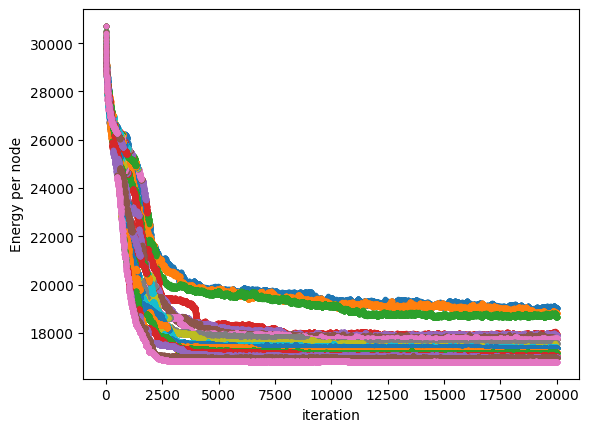

In [310]:
x=np.arange(PasosMC)
for k_nt in range(0,N_t):
    energies_pasos_temper = energies_pasos[0,k_nt,:] 
    plt.plot(x,energies_pasos_temper,'.',label='%s temper' % tempers[k_nt])
    plt.xlabel('iteration')
    plt.ylabel('Energy per node')
# plt.legend()

In [311]:
runs

10